In [33]:
# import sqlalchemy
import sqlite3
import pandas as pd

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Connect to SQLite database
connection = sqlite3.connect(r'../data/vivino.db')
# Create a cursor object
cursor = connection.cursor()

## Specific combination of tastes

- We have detected that a big cluster of customers like a specific combination of tastes. 
- We have identified a few primary keywords that match this. 
- We would like you to find all the wines that have those keywords. 
- To ensure the accuracy of our selection, ensure that more than 10 users confirmed those keywords. 
- Also, identify the group_name related to those keywords.

Keywords:

- coffee
- toast
- green apple
- cream
- citrus

### Select and count keywords + flavor groups = tastes

In [36]:
query_taste_count = """
    SELECT keywords.name || ' (' || keywords_wine.group_name || ')' AS group_flavor,
           COUNT(keywords_wine.keyword_type) AS count
    FROM keywords_wine
        JOIN keywords on keywords_wine.keyword_id = keywords.id
        JOIN flavor_groups on keywords_wine.group_name = flavor_groups.name
    WHERE keywords.name IN ("coffee", "toast", "green apple", "cream", "citrus") AND
          keywords_wine.count > 10
    GROUP BY group_flavor
    ORDER BY count DESC
    ;
"""
df_taste_count = pd.read_sql_query(query_taste_count, connection)
print(df_taste_count.shape)
display(df_taste_count)

(7, 2)


,group_flavor,count
0,coffee (oak),310
1,coffee (non_oak),310
2,cream (microbio),257
3,toast (non_oak),179
4,toast (microbio),179
5,citrus (citrus_fruit),137
6,green apple (tree_fruit),66


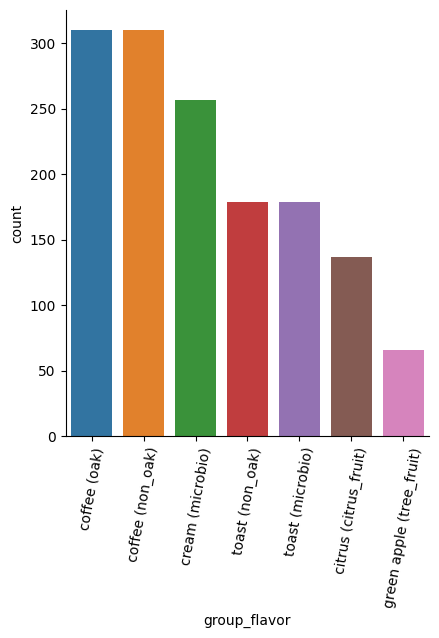

<Figure size 640x480 with 0 Axes>

In [48]:
g = sns.catplot(
	x = "group_flavor",
    y = "count",
	data = df_taste_count,
	kind = "bar"
)
g.tick_params(axis="x", rotation=80)
plt.show()
plt.clf()

### Select all keywords and other relevant info

In [37]:
query_5_tastes = """
    SELECT wines.id AS wine_id,
           wines.name AS wine_name,
           wines.ratings_average AS rating,
           keywords.name || ' (' || keywords_wine.group_name || ')' AS group_flavor
    FROM keywords_wine
        JOIN keywords on keywords_wine.keyword_id = keywords.id
        JOIN flavor_groups on keywords_wine.group_name = flavor_groups.name
        JOIN wines on keywords_wine.wine_id = wines.id
    WHERE keywords.name IN ("coffee", "toast", "green apple", "cream", "citrus") AND
          keywords_wine.count > 10
    ORDER BY rating DESC
    ;
"""
df_5_tastes = pd.read_sql_query(query_5_tastes, connection)
print(df_5_tastes.shape)
display(df_5_tastes.head(10))

(1438, 4)


,wine_id,wine_name,rating,group_flavor
0,1166837,Pomerol,4.7,coffee (oak)
1,1166837,Pomerol,4.7,coffee (non_oak)
2,1166837,Pomerol,4.7,cream (microbio)
3,1127349,Le Mesnil Blanc de Blancs (Cuvée S) Brut Champ...,4.7,citrus (citrus_fruit)
4,1127349,Le Mesnil Blanc de Blancs (Cuvée S) Brut Champ...,4.7,toast (non_oak)
5,1127349,Le Mesnil Blanc de Blancs (Cuvée S) Brut Champ...,4.7,coffee (non_oak)
6,1127349,Le Mesnil Blanc de Blancs (Cuvée S) Brut Champ...,4.7,coffee (oak)
7,1127349,Le Mesnil Blanc de Blancs (Cuvée S) Brut Champ...,4.7,cream (microbio)
8,1127349,Le Mesnil Blanc de Blancs (Cuvée S) Brut Champ...,4.7,toast (microbio)
9,1127349,Le Mesnil Blanc de Blancs (Cuvée S) Brut Champ...,4.7,green apple (tree_fruit)


#### Check if keywords are consistently doubled and can be reduced to ONE 

##### COFFEE

In [65]:
query_coffee_oak = f"""
    SELECT wines.id AS wine_id,
           wines.name AS wine_name,
           -- wines.ratings_average AS rating,
           keywords.name || ' (' || keywords_wine.group_name || ')' AS group_flavor
    FROM keywords_wine
        JOIN keywords on keywords_wine.keyword_id = keywords.id
        JOIN flavor_groups on keywords_wine.group_name = flavor_groups.name
        JOIN wines on keywords_wine.wine_id = wines.id
    WHERE keywords.name = "coffee" AND 
          keywords_wine.group_name = "oak" AND
          keywords_wine.count > 10
    ORDER BY wine_id, group_flavor
    ;
"""
df_coffee_oak = pd.read_sql_query(query_coffee_oak, connection)

query_coffee_oak = f"""
    SELECT wines.id AS wine_id,
           wines.name AS wine_name,
           -- wines.ratings_average AS rating,
           keywords.name || ' (' || keywords_wine.group_name || ')' AS group_flavor
    FROM keywords_wine
        JOIN keywords on keywords_wine.keyword_id = keywords.id
        JOIN flavor_groups on keywords_wine.group_name = flavor_groups.name
        JOIN wines on keywords_wine.wine_id = wines.id
    WHERE keywords.name = "coffee" AND 
          keywords_wine.group_name = "non_oak" AND
          keywords_wine.count > 10
    ORDER BY wine_id, group_flavor
    ;
"""
df_coffee_non_oak = pd.read_sql_query(query_coffee_oak, connection)

display(df_coffee_oak.shape)
display(df_coffee_non_oak.shape)

(310, 3)

(310, 3)

In [63]:
df_coffee = df_coffee_oak.merge(df_coffee_non_oak, on="wine_id")
display(df_coffee.shape)
display(df_coffee.head())

(310, 5)

,wine_id,wine_name_x,group_flavor_x,wine_name_y,group_flavor_y
0,1268,St. Henri Shiraz,coffee (oak),St. Henri Shiraz,coffee (non_oak)
1,1471,Siepi,coffee (oak),Siepi,coffee (non_oak)
2,1647,Solare Toscana,coffee (oak),Solare Toscana,coffee (non_oak)
3,1651,Tenuta Tignanello 'Solaia',coffee (oak),Tenuta Tignanello 'Solaia',coffee (non_oak)
4,1652,Tignanello,coffee (oak),Tignanello,coffee (non_oak)


TOAST

In [64]:
query_toast_non_oak = f"""
    SELECT wines.id AS wine_id,
           wines.name AS wine_name,
           -- wines.ratings_average AS rating,
           keywords.name || ' (' || keywords_wine.group_name || ')' AS group_flavor
    FROM keywords_wine
        JOIN keywords on keywords_wine.keyword_id = keywords.id
        JOIN flavor_groups on keywords_wine.group_name = flavor_groups.name
        JOIN wines on keywords_wine.wine_id = wines.id
    WHERE keywords.name = "toast" AND 
          keywords_wine.group_name = "non_oak" AND
          keywords_wine.count > 10
    ORDER BY wine_id, group_flavor
    ;
"""
df_toast_non_oak = pd.read_sql_query(query_toast_non_oak, connection)

query_toast_microbio = f"""
    SELECT wines.id AS wine_id,
           wines.name AS wine_name,
           -- wines.ratings_average AS rating,
           keywords.name || ' (' || keywords_wine.group_name || ')' AS group_flavor
    FROM keywords_wine
        JOIN keywords on keywords_wine.keyword_id = keywords.id
        JOIN flavor_groups on keywords_wine.group_name = flavor_groups.name
        JOIN wines on keywords_wine.wine_id = wines.id
    WHERE keywords.name = "toast" AND 
          keywords_wine.group_name = "microbio" AND
          keywords_wine.count > 10
    ORDER BY wine_id, group_flavor
    ;
"""
df_toast_microbio = pd.read_sql_query(query_toast_microbio, connection)

display(df_toast_non_oak.shape)
display(df_toast_microbio.shape)

(179, 3)

(179, 3)

In [66]:
df_toast = df_toast_non_oak.merge(df_toast_microbio, on="wine_id")
display(df_toast.shape)
display(df_toast.head())

(179, 5)

,wine_id,wine_name_x,group_flavor_x,wine_name_y,group_flavor_y
0,1471,Siepi,toast (non_oak),Siepi,toast (microbio)
1,1651,Tenuta Tignanello 'Solaia',toast (non_oak),Tenuta Tignanello 'Solaia',toast (microbio)
2,1652,Tignanello,toast (non_oak),Tignanello,toast (microbio)
3,1658,Tenuta Guado al Tasso Bolgheri Superiore,toast (non_oak),Tenuta Guado al Tasso Bolgheri Superiore,toast (microbio)
4,1675,Pian delle Vigne Brunello di Montalcino,toast (non_oak),Pian delle Vigne Brunello di Montalcino,toast (microbio)


### !!! Select all keywords and other relevant info (CLEAN) !!!



In [80]:
query_5_tastes_clean = """
    SELECT wines.id AS wine_id,
           wines.name AS wine_name,
           wines.ratings_average AS rating,
           keywords.name || ' (' || keywords_wine.group_name || ')' AS group_flavor
    FROM keywords_wine
        JOIN keywords on keywords_wine.keyword_id = keywords.id
        JOIN flavor_groups on keywords_wine.group_name = flavor_groups.name
        JOIN wines on keywords_wine.wine_id = wines.id
    WHERE keywords.name IN ("coffee", "toast", "green apple", "cream", "citrus") AND
          keywords_wine.group_name <> "non_oak" AND
          keywords_wine.count > 10
    ORDER BY wine_id ASC, group_flavor ASC
    ;
"""
df_5_tastes_clean = pd.read_sql_query(query_5_tastes_clean, connection)
print(df_5_tastes_clean.shape)
display(df_5_tastes_clean.head(10))

(949, 4)


,wine_id,wine_name,rating,group_flavor
0,1268,St. Henri Shiraz,4.4,coffee (oak)
1,1268,St. Henri Shiraz,4.4,cream (microbio)
2,1471,Siepi,4.4,coffee (oak)
3,1471,Siepi,4.4,toast (microbio)
4,1647,Solare Toscana,4.2,coffee (oak)
5,1651,Tenuta Tignanello 'Solaia',4.6,coffee (oak)
6,1651,Tenuta Tignanello 'Solaia',4.6,cream (microbio)
7,1651,Tenuta Tignanello 'Solaia',4.6,toast (microbio)
8,1652,Tignanello,4.5,citrus (citrus_fruit)
9,1652,Tignanello,4.5,coffee (oak)


In [86]:
flavor_count_per_wine = df_5_tastes_clean\
    .groupby(["wine_id", "wine_name", "rating"])[["group_flavor"]]\
    .agg(lambda x: ', '.join(x))
flavor_count_per_wine = flavor_count_per_wine.reset_index()
flavor_count_per_wine = flavor_count_per_wine.set_index("wine_id")
flavor_count_per_wine["flavor_count"] = flavor_count_per_wine["group_flavor"].apply(lambda x: len(x.split(", ")))
display(type(flavor_count_per_wine))
display(flavor_count_per_wine.shape)
display(flavor_count_per_wine.head())

pandas.core.frame.DataFrame

(429, 4)

,wine_name,rating,group_flavor,flavor_count
wine_id,,,,
1268,St. Henri Shiraz,4.4,"coffee (oak), cream (microbio)",2
1471,Siepi,4.4,"coffee (oak), toast (microbio)",2
1647,Solare Toscana,4.2,coffee (oak),1
1651,Tenuta Tignanello 'Solaia',4.6,"coffee (oak), cream (microbio), toast (microbio)",3
1652,Tignanello,4.5,"citrus (citrus_fruit), coffee (oak), cream (mi...",4


In [88]:
display(len(flavor_count_per_wine["group_flavor"].unique()))

16

In [100]:
top_combos = flavor_count_per_wine.groupby("group_flavor")[["rating"]].mean()
top_combos = top_combos.sort_values("rating", ascending=False)
top_combos = top_combos.reset_index()
display(top_combos)

,group_flavor,rating
1,"citrus (citrus_fruit), coffee (oak), cream (mi...",4.570588
9,"citrus (citrus_fruit), toast (microbio)",4.500000
11,"coffee (oak), cream (microbio)",4.479167
2,"citrus (citrus_fruit), coffee (oak), cream (mi...",4.469231
7,"citrus (citrus_fruit), cream (microbio), toast...",4.457143
0,citrus (citrus_fruit),4.440000
4,"citrus (citrus_fruit), cream (microbio)",4.434615
10,coffee (oak),4.431655
12,"coffee (oak), cream (microbio), toast (microbio)",4.430952
6,"citrus (citrus_fruit), cream (microbio), green...",4.417143


c:\Users\vital\Learning\GitHub\Wiwinio-Project\_project_env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


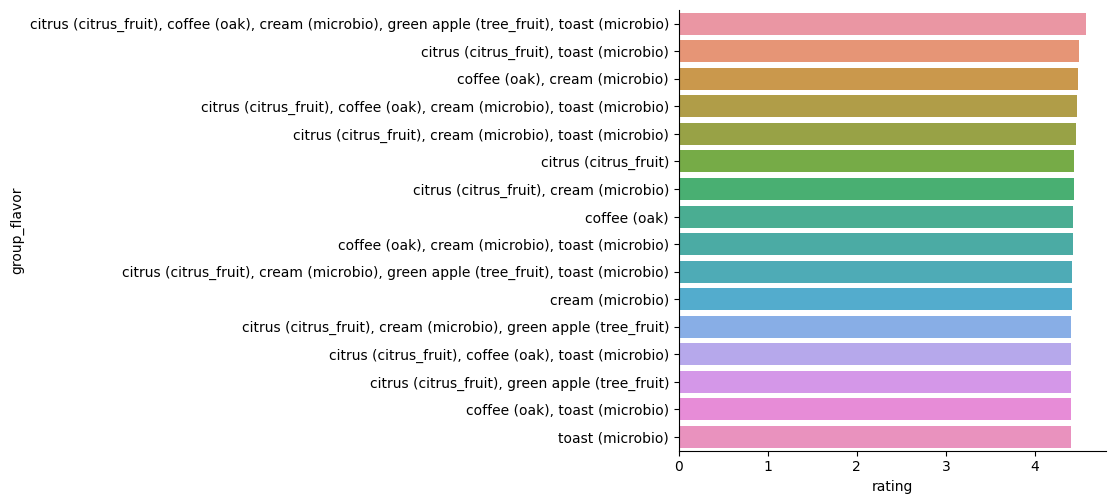

<Figure size 640x480 with 0 Axes>

In [102]:
sns.catplot(
	x = "rating",
    y = "group_flavor",
	data = top_combos,
    kind="bar"
)
plt.show()
plt.clf()